# Технічний воркшоп: "Як створити проект на основі відкритих даних"

## Необхідні бібілотеки

In [1]:
import pandas as pd
import requests
import json
import re
from pprint import pprint as pp
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns # надбудова для спрошення побудови графіків

## NOMINANTUM

https://nominatim.org/release-docs/develop/api/Overview/ - Документація
https://nominatim.openstreetmap.org/reverse?format=json&lat=50.433776&lon=30.540501&zoom=18&addressdetails=1 - приклад даних
https://nominatim.openstreetmap.org/?addressdetails=1&q=10/8,%D0%93%D1%83%D1%81%D0%BE%D0%B2%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE,%D0%B2%D1%83%D0%BB%D0%B8%D1%86%D1%8F,%D0%9A%D0%B8%D1%97%D0%B2&format=json&limit=1 - приклад даних

In [2]:
# Отримати адресу за координатами

lat = ["50.433776","50.461367","50.44821",]
lon = ["30.540501","30.621157","30.513893",]

house_number = []
road = []
suburb = []
borough = []
city = []


for i in range (0, len(lat)):
    cordinates = requests.get("https://nominatim.openstreetmap.org/reverse?format=json&lat=" + str(lat[i])+"&lon=" + str(lon[i])+"&zoom=18&addressdetails=1").json()
    try:
        try:
            house_number.append(cordinates["address"]["house_number"])
        except:
            house_number.append("null")
        try:
            road.append(cordinates["address"]["road"])
        except:
            road.append("null")
        try:
            suburb.append(cordinates["address"]["suburb"])
        except:
            suburb.append("null")
        try:
            borough.append(cordinates["address"]["borough"])
        except:
            borough.append("null")
        try:
            city.append(cordinates["address"]["city"])
        except:
            city.append("null")
        time.sleep(1)
    except:
        pass
        

packages_df =  pd.DataFrame({"lat" : lat,
                             "lon" : lon,
                             "house_number": house_number,
                             "road": road,                             
                             "suburb": suburb,
                             "borough":borough,
                             "city": city
                            })
packages_df

,lat,lon,house_number,road,suburb,borough,city
0,50.433776,30.540501,10/8,Гусовського вулиця,Печерськ,Печерський район,Київ
1,50.461367,30.621157,19а,Андрія Малишка вулиця,Лівобережний масив,Дніпровський район,Київ
2,50.44821,30.513893,42,Володимирська вулиця,Центр,Шевченківський район,Київ


In [3]:
# Отримати координати за адресою
lat_one = []
lon_one = []

for i in range (0, len(city)):
    request = requests.get("https://nominatim.openstreetmap.org/?addressdetails=1&q=" + str(house_number[i]) + "," + str(road[i]) + "," + str(city[i]) + "&format=json&limit=1").json()
    try:
        try:
            lat_one.append(request[0]["lat"])
        except:
            lat_one.append("null")
        try:
            lon_one.append(request[0]["lon"])
        except:
            lon_one.append("null")
    except:
        pass
    
packages_df =  pd.DataFrame({"lat_one" : lat_one,
                             "lon_one" : lon_one,
                             "house_number": house_number,
                             "road": road,                             
                             "city": city
                            })
packages_df

,lat_one,lon_one,house_number,road,city
0,50.43386975,30.540575402259474,10/8,Гусовського вулиця,Київ
1,50.4614098,30.62113181013427,19а,Андрія Малишка вулиця,Київ
2,50.4483922,30.5139104,42,Володимирська вулиця,Київ


## Regex

https://regex101.com/ - інструмент для перевірки регулярних виразів
https://uk.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%B8%D0%B9_%D0%B2%D0%B8%D1%80%D0%B0%D0%B7 - перелік виразів

In [125]:
data = pd.read_csv("regex.csv")

In [126]:
data.head()

,subject,doc_num,type,info_num,name,num,exp,imp,date
0,"ТОВ ""МЕГАТЕКС""",05.03.2015 № 5335/10-15,імпорт,UA 000 422і,брухт та відходи свинцевих акумуляторних батарей,1 000 т,"АО ""METALFEROS"" (Молдова)","ТОВ ""МЕГАТЕКС""",24.03.2015
1,"ТОВ ""МЕГАТЕКС""",18.02.2015 № 3878/10-15,імпорт,UA 000 423і,відходи свинцю та свинцевих сплавів,18720 кг,"ВАТ ""БЕЛЦВЕТМЕТ"" (Білорусь)","ТОВ ""МЕГАТЕКС""",02.04.2015
2,"ПАТ ""АЗОКМ""",24.02.2015 № 4373/10-15,експорт,UA 000 424,"шлак, що містить мідь",1250 т,"ПАТ ""АЗОКМ""",Grass AFGmbH,15.04.2015
3,"ПАТ ""АЗОКМ""",24.02.2015 № 4375/10-15,експорт,UA 000 425,"шлак, що містить мідь",1250 т,"ПАТ ""АЗОКМ""",Siegfried Jacob Metallwerke GmbH,15.04.2015
4,"ТОВ ""СП ЕКОМЕТАЛ""",24.03.2015 № 7054/10-15,експорт,UA 000 426,"шлак, що містить мідь",500 т,"ТОВ ""СП ЕКОМЕТАЛ""",Siegfried Jacob Metallwerke GmbH,20.04.2015


In [127]:
# перевіряємо кількість пропущених значень в датасеті
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

subject - 0%
doc_num - 0%
type - 0%
info_num - 0%
name - 0%
num - 0%
exp - 0%
imp - 0%
date - 0%


<AxesSubplot:>

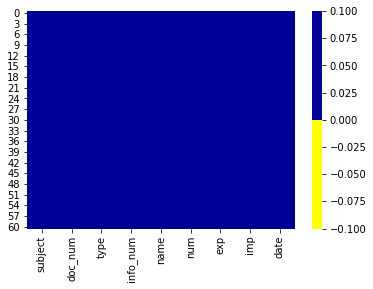

In [129]:
cols = data.columns
# визначаємо кольори
# жовтий - пропущені значення, синій - дійсні значення
colours = ['#ffff00', '#000099'] 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

In [130]:
data["subject"].unique()

array(['ТОВ "МЕГАТЕКС"', 'ПАТ "АЗОКМ"', 'ТОВ "СП ЕКОМЕТАЛ"',
       'ТОВ "РЕНАК"', 'ПАТ "СВИНЕЦЬ"', 'ТОВ "Екологічні інвестиції"',
       'ТОВ "Інтертрейд крейшн"', 'ТОВ "Сучасні технолології"',
       'Міністерство оборони Республіки Молдова', 'ТОВ "Екотехнологія"',
       'Міністерство ОНПС Республіки Молдова', 'ТОВ "СП СВИНЕЦЬ"',
       'ТОВ "ІНТЕРТРЕЙДКРЕШН"', 'ПП "ПОЛІМЕТ"',
       'ТОВ "Сучасні технології"', 'ТОВ "ПРІСТА РІСАЙКЛІН Україна"',
       'ТОВ "УКРБІОЕКОЛОГІЯ"', 'ТОВ "СІГМАС ЕКОЛОДЖИ"', 'ДП "БОДНАРІВКА"',
       'ТОВ КЗМО', 'ТОВ "ЕНЕРГОТЕХ"'], dtype=object)

In [131]:
data["subject_type"] = data["subject"]

In [135]:
data["subject_type"] = data["subject_type"].str.replace(r"ТОВ.*", r"Товариство з обмеженою відповідальністю", regex = True)
data["subject_type"] = data["subject_type"].str.replace(r"ПАТ.*", r"Публічне акціонерне товариство", regex = True)
data["subject_type"] = data["subject_type"].str.replace(r"ПП.*", r"Приватне підприємство", regex = True)
data["subject_type"] = data["subject_type"].str.replace(r"Міністерство.*", "Державний орган", regex = True)
data["subject_type"] = data["subject_type"].str.replace(r"ДП.*", "Державне підприємство", regex = True)

In [136]:
data["subject_type"].unique()

array(['Товариство з обмеженою відповідальністю',
       'Публічне акціонерне товариство', 'Державний орган',
       'Приватне підприємство', 'Державне підприємство'], dtype=object)

In [139]:
data["name_type"] = data["name"]
data["name_type"].unique()

array(['брухт та відходи свинцевих акумуляторних батарей',
       'відходи свинцю та свинцевих сплавів', 'шлак, що містить мідь',
       'залишки металургійної обробки брухту міді',
       'відпрацьовані акумулятори, що містять свинець',
       'шлак,шлам,що містить переважно мідь',
       'змішані відходи пестицидів та забруднених упаковок',
       'тара забруднена токсичними речовинами',
       'шлак, зола, що містить мідь', 'шлак мідний',
       'агрохімічні відходи', 'шлак,зола та залишки, що містять мідь',
       'непридатні пестициди', 'відходи свинцевих акумуляторів',
       'шлак мідєвмістний', 'відпрацьовані оливи (масла)',
       'відпрацьовані батарейки', 'мідєвмісний шлак',
       'агрохімічні відходи, що містять СОЗ',
       'відпрацьовані акумулятори свинц.пластин',
       'несортовані відпрацьовні батареї',
       'змішані відпрацьовані батареї',
       'відпрацьовані свинцеві акумулятори', 'змішані пестициди',
       'мідєвмісний шлам', 'пестициди', 'промислові відходи 

In [150]:
data["name_type"] = data["name_type"].str.replace(r".*свинц.*|.*свинец.*", r"свинець", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*мідь.*|.*мідє.*|.*міді.*", r"мідь", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*пестици.*", r"пестициди", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*пластик.*", r"пластик", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*агрохім.*", r"агрохімічні відходи", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*олив.*|.*масл.*", r"оливи та масла", regex = True)
data["name_type"] = data["name_type"].str.replace(r".*батаре.*", r"батареї", regex = True)

In [151]:
data["name_type"].unique()

array(['свинець', 'мідь', 'пестициди',
       'тара забруднена токсичними речовинами', 'шлак мідний',
       'агрохімічні відходи', 'оливи та масла', 'батареї', 'пластик'],
      dtype=object)

In [168]:
data["doc_num_num"] = data["doc_num"]

In [169]:
data["doc_num_num"].unique()

array(['05.03.2015 № 5335/10-15', '18.02.2015 № 3878/10-15',
       '24.02.2015 № 4373/10-15', '24.02.2015 № 4375/10-15',
       '24.03.2015 № 7054/10-15', '16.12.2015 № 31206/10-15',
       '290/10-16 від 06.01.2015', '21.01.2015 № 31563/10-15',
       '02.02.2015 № 2725/10-16', '№ 1682/10-16 від 22.01.2016',
       '11429/10-16 від 06.05.2016', '10385/10-16 від 22.04.2016',
       '20446/10-16 від 16.08.2016', '14522/7-16 від 14.06.2020',
       '24674/10-16 від 05.10.2016', '22813/10-16 від 13.09.2016',
       '28020/10-16 від 07.11.2016', '28.12.2016 № 32188/10-16',
       '№ 31418/7-16 від 20.12.2016', '27199/10-16 від 28.12.2016',
       '28403/10-16 від 16.11.2016', '2834/10-17 від 02.02.2017',
       '4758/10-17 від 21.02.2017', '3386/7-17 від 08.02.2017',
       '6929/10-17 від 15.03.2017', '23124/10-16 від 12.09.2017',
       '27236/10-17 від 30.10.2017', '30402/10-17 від 28.11.2017',
       '33350/10-17 від 26.12.2017', '6243/10-18 від 02.03.2018',
       '28952/10-17 від 14

In [170]:
data["doc_num_num"] = data["doc_num_num"].str.replace(r"(.*).*від.*", r"\1", regex = True)
data["doc_num_num"] = data["doc_num_num"].str.replace(r".*№(.*)", r"\1", regex = True)

In [171]:
data["doc_num_num"].unique()

array([' 5335/10-15', ' 3878/10-15', ' 4373/10-15', ' 4375/10-15',
       ' 7054/10-15', ' 31206/10-15', '290/10-16 ', ' 31563/10-15',
       ' 2725/10-16', ' 1682/10-16 ', '11429/10-16 ', '10385/10-16 ',
       '20446/10-16 ', '14522/7-16 ', '24674/10-16 ', '22813/10-16 ',
       '28020/10-16 ', ' 32188/10-16', ' 31418/7-16 ', '27199/10-16 ',
       '28403/10-16 ', '2834/10-17 ', '4758/10-17 ', '3386/7-17 ',
       '6929/10-17 ', '23124/10-16 ', '27236/10-17 ', '30402/10-17 ',
       '33350/10-17 ', '6243/10-18 ', '28952/10-17 ', '6246/10-18 ',
       '24580/10-18 ', '22505/10-18 ', '30572/1-10-18 ', '32498/10-18 ',
       '37134/10-18 ', '679/10-19 ', '15874/10-19 ', '9258/10-18 ',
       '26414/10-19 ', '26071/10-19 ', '28131/10-19 ', '12вх/254-19 ',
       '29078/10-19 ', '12вх/59-19 ', '1/16/2125-20 ', '1/16/6345-20 ',
       '2737/10/20 ', '4957/10/20 ', '5664/10/20 ', '6691/10/20 ',
       '8987/10/20 ', '10179/10/20 ', '12171/10/20 ', '11240/10/20 ',
       '20558/10/20 ', '962

In [181]:
data["doc_num_date"] = data["doc_num"]

In [184]:
data["doc_num_date"].unique()

array(['05.03.2015', '18.02.2015', '24.02.2015', '24.03.2015',
       '16.12.2015', '06.01.2015', '21.01.2015', '02.02.2015',
       '22.01.2016', '06.05.2016', '22.04.2016', '16.08.2016',
       '14.06.2020', '05.10.2016', '13.09.2016', '07.11.2016',
       '28.12.2016', '20.12.2016', '16.11.2016', '02.02.2017',
       '21.02.2017', '08.02.2017', '15.03.2017', '12.09.2017',
       '30.10.2017', '28.11.2017', '26.12.2017', '02.03.2018',
       '14.11.2017', '28.08.2020', '07.08.2018', '24.10.2018',
       '13.11.2018', '27.12.2018', '09.01.2019', '22.05.2019',
       '26.03.2019', '23.08.2019', '21.08.2019', '11.09.2019',
       '26.12.2019', '19.09.2019', '26.11.2019', '14.01.2020',
       '03.02.2020', '21.07.2020', '03.08.2020', '05.08.2020',
       '12.08.2020', '31.08.2020', '09.09.2020', '23.09.2020',
       '16.09.2020', '19.11.2020', '04.09.2020', '28.12.2020',
       '03.12.2020'], dtype=object)

In [183]:
data["doc_num_date"] = data["doc_num_date"].str.replace(r".*(\d\d.\d\d.\d\d\d\d).*", r"\1", regex = True)

## API PROZORRO

In [110]:
list__of_tenders = requests.get("https://public.api.openprocurement.org/api/2.5/tenders?offset=2015-06-19").json()

tenders = []
urls = []
titles = []
sums = []

for i in list__of_tenders["data"]:
        tender = requests.get("https://public.api.openprocurement.org/api/2.5/tenders/" + str(i["id"])).json()
        urls.append("https://prozorro.gov.ua/tender/" + str(tender["data"]["tenderID"]))
        titles.append(tender["data"]["title"])
        sums.append(tender["data"]["value"]["amount"])
        

packages_df =  pd.DataFrame({"url" : urls,
                             "title" : titles,
                             "sum": sums
                            })
packages_df

,url,title,sum
0,https://prozorro.gov.ua/tender/UA-2015-06-11-0...,Бензин А-95,50000.0
1,https://prozorro.gov.ua/tender/UA-2015-06-18-0...,Послуги з експлуатації спортивних споруд,12960.0
2,https://prozorro.gov.ua/tender/UA-2015-06-18-0...,Послуги з харчування,26400.0
3,https://prozorro.gov.ua/tender/UA-2015-06-18-0...,Послуги з розміщення іногородніх учасників,16575.0
4,https://prozorro.gov.ua/tender/UA-2015-06-18-0...,Патрон Nammo Schonebeck SK RIFLE MATCH 22 LR,57600.0
...,...,...,...
95,https://prozorro.gov.ua/tender/UA-2015-08-11-0...,мило тверде,50.0
96,https://prozorro.gov.ua/tender/UA-2015-08-11-0...,файл канцелярський,80.0
97,https://prozorro.gov.ua/tender/UA-2015-08-07-0...,"«Мотузки, канати, шпагат і сіткове полотно, кр...",36799.0
98,https://prozorro.gov.ua/tender/UA-2015-08-06-0...,Бензин А-92 та Дизпаливо,2630.0


## API Data.gov.ua

https://data.gov.ua/api/3/action/package_list - перелік наборів даних
https://data.gov.ua/api/3/action/organization_show?id=tax&include_datasets=true - пошук наборів розпорядника

https://data.gov.ua/pages/aboutuser2 - опис АРІ

In [4]:
#Запит на отримання всіх наборів даних
response = requests.get("https://data.gov.ua/api/3/action/package_list").json()
len(response["result"])

36159

In [37]:
#Запит на отримання наборів даних Мінеко

response = requests.get("https://data.gov.ua/api/3/action/organization_show?id=ministerstvo-ekolohiyi-ta-pryrodnykh-resursiv-ukrayiny&include_datasets=true").json()
response["result"]

{'users': [{'email_hash': '0fc6f8d5dfe6ed23a7441e022a873ab1',
   'about': '',
   'capacity': 'admin',
   'name': 'default',
   'created': '2018-08-08T14:04:44.915899',
   'openid': None,
   'sysadmin': True,
   'activity_streams_email_notifications': False,
   'state': 'active',
   'number_of_edits': 93937,
   'display_name': 'default',
   'fullname': '',
   'id': '299ffe82-f956-4446-b7e9-19a9bdee4db5',
   'number_created_packages': 1969},
  {'email_hash': '38a2c68138415f92207d8bdc4594095e',
   'about': '',
   'capacity': 'admin',
   'name': 'taisa_570',
   'created': '2018-08-08T19:08:37.979152',
   'openid': None,
   'sysadmin': False,
   'activity_streams_email_notifications': False,
   'state': 'active',
   'number_of_edits': 611,
   'display_name': 'Міндовкілля',
   'fullname': 'Міндовкілля',
   'id': '94b388a6-6f56-487c-ba29-d5668ece67a2',
   'number_created_packages': 35}],
 'display_name': 'Міністерство захисту довкілля та природних ресурсів України',
 'description': 'Міністерс

## АРІ INSPECTIONS

https://docs.google.com/document/d/1YQMEEFf_EtuZMud2OVYeVpi3aDE6lsuUqFrsbzS5RKk/edit - документація
https://inspections.gov.ua/ - інспекційний портал

360d858edaac8313a73d237f340138c097ab6304 - тестовий ключ (обмеження - 100 запитів на годину) (https://inspections.gov.ua/article/view?id=30)

https://inspections.gov.ua/dashboard/#/basic - аналітичний модуль

In [193]:
lists = requests.get("http://api.ias.brdo.com.ua/v1_1/inspection?apiKey=360d858edaac8313a73d237f340138c097ab6304&orderBy=desc").json()

JSONDecodeError: Expecting value: line 1 column 5 (char 4)

In [190]:
lists

<Response [500]>

## API ProzorroSales

Точки доступу АРІ https://docs.google.com/document/d/1BQWnsly97yotWHJTKl282hjZqHaDVWAO7pIzSk5N9qI/edit

### стара процедура

In [10]:
# перебираємо всі сторінки із аукціонами
date = "2016-01-01" #можемо обрати будь яку дату для початку перебору
response = requests.get("https://public.api.ea.openprocurement.org/api/2/auctions?offset=" + str(date)+"T20%3A02%3A53.109988%2B02%3A00").json()
pages = [response["next_page"]["uri"]]
for i in pages:
    uri = requests.get(str(i)).json()
    pages.append(uri["next_page"]["uri"])
    print(len(pages))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


KeyboardInterrupt: 

In [11]:
# збираємо всі id та дати оглошень про аукціони
au_id = []
au_date = []
for z in pages:
    page = requests.get(z).json()
    for y in page["data"]:
        au_id.append(y["id"])
        au_date.append(y["dateModified"])
    print(len(au_id), " : ", len(au_date))
    

100  :  100
200  :  200
300  :  300
400  :  400
500  :  500
600  :  600
700  :  700
800  :  800
900  :  900
1000  :  1000
1100  :  1100
1200  :  1200
1300  :  1300
1400  :  1400
1500  :  1500
1600  :  1600
1700  :  1700
1800  :  1800


In [12]:
# можна зберегти значення в датафрейм пандас

packages_df =  pd.DataFrame({"au_id" : au_id,
                             "au_date" : au_date,
                            })
packages_df


,au_id,au_date
0,81ec3cfd0bf14e99bdd18ec2e5ecfaea,2016-11-28T20:03:15.358052+02:00
1,a16d5b880d1a4b5a90783b5715a7f3a0,2016-11-28T20:03:15.443664+02:00
2,1ecce47fd28742b29b7310148be07f03,2016-11-28T20:03:16.246572+02:00
3,409a070b0aa046bb8e27b9295716ac5d,2016-11-28T20:03:19.209992+02:00
4,2a1aad85d1e94773a165132be342b2da,2016-11-28T20:03:22.140007+02:00
...,...,...
1795,e85f47405cc44539a229b305eda61859,2017-01-31T20:02:08.127735+02:00
1796,ecda4f79017043798c9ff46a8987ca30,2017-01-31T20:02:10.127096+02:00
1797,7937f445cade4595a0a110289953af69,2017-01-31T20:02:10.297032+02:00
1798,01163c79aa604f79b85d86db0c66ad62,2017-01-31T20:02:11.131790+02:00


In [14]:
# дивимось окремі аукціони
endpoint = "https://public.api.ea.openprocurement.org/api/2/auctions/"

for uri in au_id:
    print(endpoint+str(uri))
    auction = requests.get(endpoint+str(uri)).json()
    print(auction["data"]["auctionID"])

https://public.api.ea.openprocurement.org/api/2/auctions/81ec3cfd0bf14e99bdd18ec2e5ecfaea
UA-EA-2016-10-31-000004
https://public.api.ea.openprocurement.org/api/2/auctions/a16d5b880d1a4b5a90783b5715a7f3a0
UA-EA-2016-10-31-000017
https://public.api.ea.openprocurement.org/api/2/auctions/1ecce47fd28742b29b7310148be07f03
UA-EA-2016-10-31-000020
https://public.api.ea.openprocurement.org/api/2/auctions/409a070b0aa046bb8e27b9295716ac5d
UA-EA-2016-11-14-000079
https://public.api.ea.openprocurement.org/api/2/auctions/2a1aad85d1e94773a165132be342b2da
UA-EA-2016-11-14-000072
https://public.api.ea.openprocurement.org/api/2/auctions/017af3c079cf44d79b93786feb509363
UA-EA-2016-11-14-000077
https://public.api.ea.openprocurement.org/api/2/auctions/db064f6246f441d3bdb303c94d786a7a
UA-EA-2016-11-14-000082
https://public.api.ea.openprocurement.org/api/2/auctions/ae53c975d36643e6bb5a8793d847ba6c
UA-EA-2016-10-31-000016
https://public.api.ea.openprocurement.org/api/2/auctions/890d1b3bfe5c40858db7cf7bbdcc65a

KeyboardInterrupt: 

### Нова процедура

In [107]:
# перебираємо всі сторінки
uri = "https://procedure.prozorro.sale/api/search/byDateModified/2020-01-01T00:00:00.000000Z?limit=100"
pages = [uri ]
for i in pages:
    response = requests.get(i).json()
    time = response[-1]["dateModified"]
    time = datetime.strptime(response[-1]["dateModified"], 
                             "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(milliseconds = 1)
    pages.append("https://procedure.prozorro.sale/api/search/byDateModified/"
                 + str(response[-1]["dateModified"])+ "?limit=100")
    for z in response:
        print(z["_id"]) # оскільки ми отримємо відразу всі сторінки можемо відразу їх парсити

5f644aff4833837ac6a8fecd
5f64499fa534a15ae82e586a
5f644a6af01fd3a7e9d4722c
5f636738d078e4ceb2bb03a8
5f6224a804f64d2cd9432b8f
5f6c9ce59afb22e74869369c
5f5b6b7af6ec035ce566ff18
5f5f4f6d74af5d1ff4f60359
5f5f4f7385f4f1b8c6d6f749
5f5f682f36d7107f091d5947
5f5f683685f4f1b8c6d6f74b
5f5f683974af5d1ff4f6035b
5f5f684085f4f1b8c6d6f74d
5f5f684636d7107f091d5949
5f5f720274af5d1ff4f6035f
5f5f721c74af5d1ff4f60361
5f5f722336d7107f091d594b
5f5f722a85f4f1b8c6d6f751
5f5f723085f4f1b8c6d6f753
5f5f729d74af5d1ff4f60363
5f5f729785f4f1b8c6d6f755
5f5f72a485f4f1b8c6d6f757
5f5f72aa74af5d1ff4f60365
5f5f72b085f4f1b8c6d6f759
5f5f72fc74af5d1ff4f60367
5f5f730236d7107f091d594f
5f5f72f636d7107f091d594d
5f5f731685f4f1b8c6d6f75b
5f5f731c36d7107f091d5951
5f5f732136d7107f091d5953
5f5f806a36d7107f091d5955
5f5f807074af5d1ff4f60369
5f5f807785f4f1b8c6d6f75d
5f5f807b85f4f1b8c6d6f75f
5f5f808185f4f1b8c6d6f761
5f5f808785f4f1b8c6d6f763
5f5f808d74af5d1ff4f6036b
5f5f809436d7107f091d5957
5f5f809a36d7107f091d5959
5f5f80a085f4f1b8c6d6f765


5f64a4aef01fd3a7e9d47252
5f64a4d6a534a15ae82e5895
5f64a50f4833837ac6a8fefe
5f64a53ff01fd3a7e9d47254
5f64a5764833837ac6a8ff00
5f64a57ba534a15ae82e5897
5f64a5a74833837ac6a8ff02
5f64a5e0a534a15ae82e5899
5f64a61af01fd3a7e9d47256
5f64a631f01fd3a7e9d47258
5f64a64bf01fd3a7e9d4725a
5f64a674a534a15ae82e589b
5f64a675f01fd3a7e9d4725c
5f64a8744833837ac6a8ff04
5f64ad7aa534a15ae82e589d
5f64adf34833837ac6a8ff06
5f64ae76f01fd3a7e9d4725e
5f64b0d1f01fd3a7e9d47264
5f64b358a534a15ae82e589f
5f64b49e4833837ac6a8ff08
5f7327f44e72f99116f52e55
5f7325f272536fd7971a2068
5f732040e50bbb352fa1c9a0
5f7321d84e72f99116f52e4e
5f731ecbe50bbb352fa1c99e
5f731d6872536fd7971a2061
5f731af772536fd7971a205e
5f7317bb72536fd7971a2059
5f64665af01fd3a7e9d47235
5f6df6bd91bd385baa937ded
5f6b39715a8de9b369379034
5f6df4e72b133c577c2d291f
5f71eb56e13df8fed97ad90c
5f72f2fc4e72f99116f52e10
5f73118f4e72f99116f52e42
5f6df37bd3ee448d2e5ddab1
5f6def8a91bd385baa937de8
5f6dec2891bd385baa937ddb
5f633a57ad808f32ab8e3f70
5f633a0ad078e4ceb2bb0332


KeyboardInterrupt: 

#### response[1]